In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

# set default figsize to be large
mpl.rcParams['figure.figsize'] = (15, 8)

# Hello world Fashion MNIST Classifier

First, we're going to create a very simple image classifier on the Fasion MNIST data set, just to get our feet wet with TensorFlow.

Note that this **isn't** the same as the MNIST dataset, which is composed of numbers. These will be pictures of articles of clothing. 

The labels will be the type of clothing that it's an example of, such as "Ankle boot", "T-shirt/top", "Dress", etc.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Split that data into a training and test set.

In [11]:
# unpack the MNIST data into a training set, and a holdout test set
# 60,000 training               10,000 test
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# create a validation set from the last 5000 of training samples
all_except_last_5000_slice = slice(None, -5000)
last_5000_slice = slice(-5000, None)
X_train, y_train = X_train_full[all_except_last_5000_slice], y_train_full[all_except_last_5000_slice]
X_valid, y_valid = X_train_full[last_5000_slice], y_train_full[last_5000_slice]

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_valid.shape}")
print(f"Validation labels shape: {y_valid.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (55000, 28, 28)
Training labels shape: (55000,)
Validation features shape: (5000, 28, 28)
Validation labels shape: (5000,)
Testing features shape: (10000, 28, 28)
Testing labels shape: (10000,)


Here, we see that we basically have 60,000 training samples, and 10,000 testing samples. In addition, we have images that are composed of 28x28 matrices, where each value represents a pixel intensity.

In addition, we've split our training samples into training and validation sets. In this example, we'll be using the validation set to tune hyperparameters, and we won't touch the test set until the very end. So you'll see the training and validation sets being used during training, and you'll see the test set during `evaluate`.

This is what a single instance of our training data looks like:

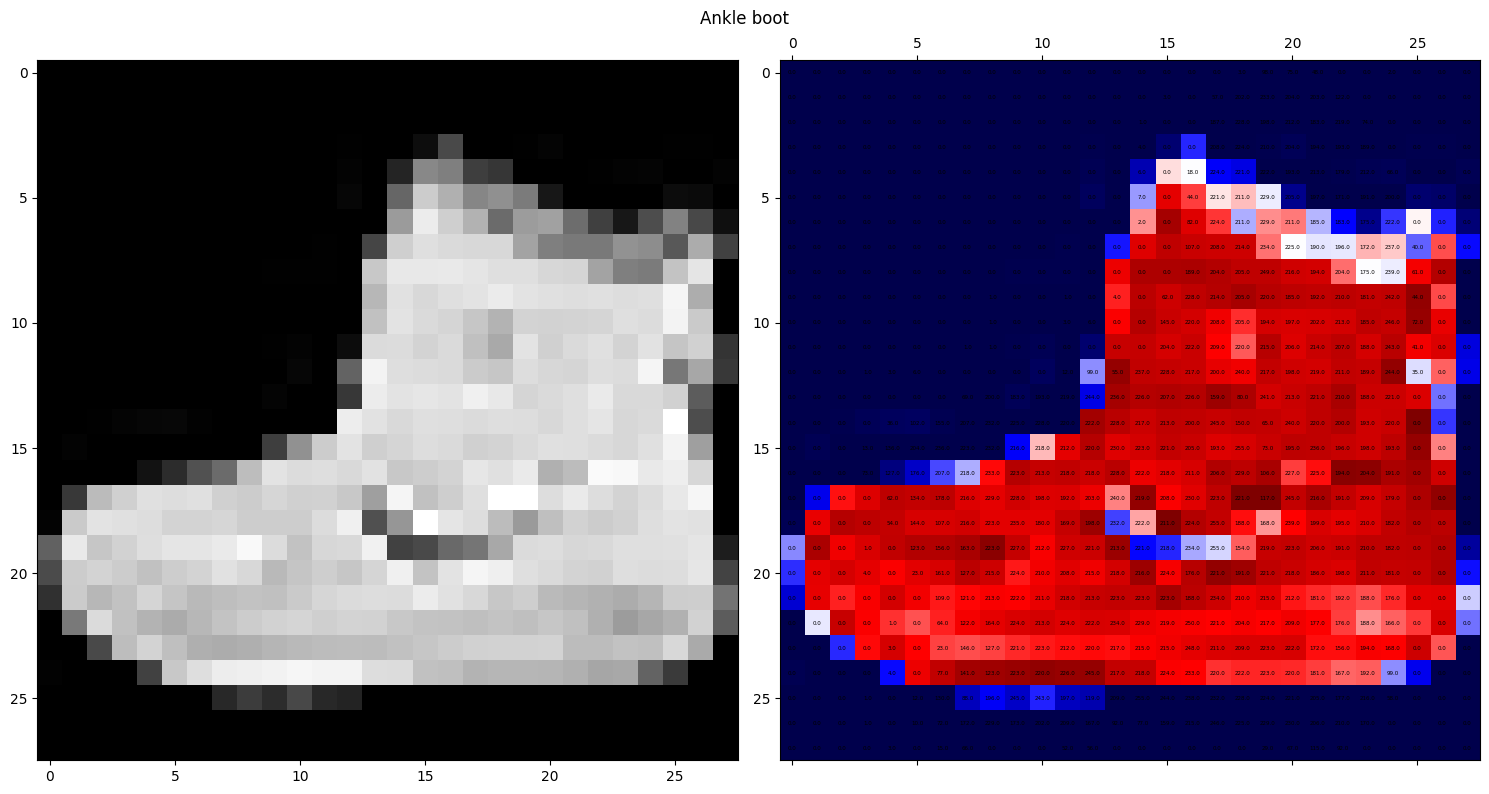

In [4]:
import itertools
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X=X_train[0], cmap='gray')
ax[1].matshow(Z=X_train[0], cmap='seismic')

# take the cartesian product
for i, j in itertools.product(range(28), range(28)):
    value = X_train[0][i][j]
    ax[1].text(i, j, f"{value:0.1f}", ha='center', va='center', fontsize=4)

plt.suptitle(class_names[y_train[0]])
plt.tight_layout()
plt.show()

Now, let's visualize the distributions of labels.

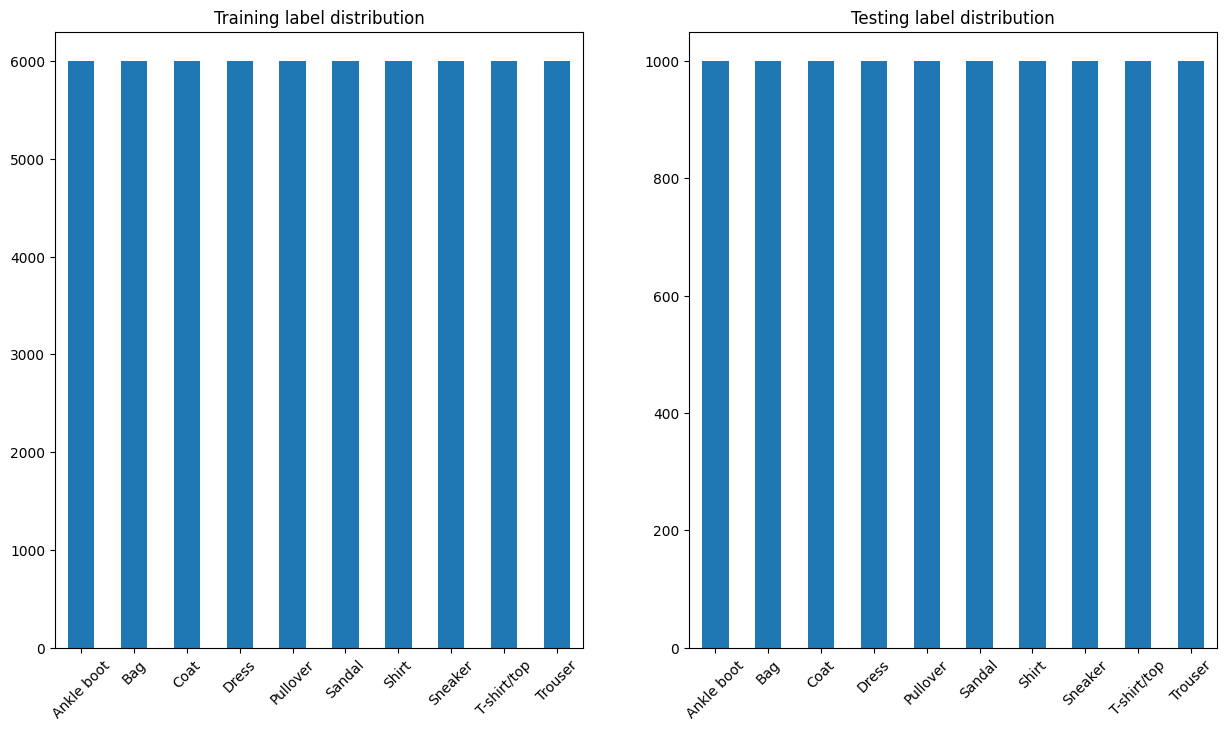

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2)
# plot train set label distributions
(
    pd.Series(y_train)
    # map each label number to its class name
    .map({i: class_names[i] for i in range(len(class_names))})
    # compute the counts for each label, and sort the labels
    .value_counts().sort_index()
).plot(ax=ax[0], kind="bar", rot=45)
# plot test set label distributions
(
    pd.Series(y_test)
    .map({i: class_names[i] for i in range(len(class_names))})
    .value_counts().sort_index()
).plot(ax=ax[1], kind="bar", rot=45)
ax[0].set_title("Training label distribution")
ax[1].set_title("Testing label distribution")
plt.show()

So as we can see, for our training labels, we have 60,000 rows and 10 categories. We can also observe that all the classes are balanced here. 

For the testing labels, we have 10,000 rows and 10 categories. They are also balanced.

Finally, we'll get to training our classifier.

First, we'll demonstrate how to use the **Sequential API** of TensorFlow (instantiate a `tf.keras.Sequential`, and repeatedly call `model.add(<keras-layer>`).
Or, you can just pass all your keras layers to the constructor for the `Sequential` model.

In [22]:
tf.random.set_seed(42) # for reproducible training

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28, 28)))
# for a batch of 32 28x28 images (of shape (32, 28, 28), flatten into a tensor of shape (32, 784)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Lambda(lambda x: x / 255.0))
model.add(tf.keras.layers.Dense(units=300, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# equivalent to:
model_sequential_list = tf.keras.Sequential([
    # note that you drop the `tf.keras.layers.Input` layer here, and pass the input shape
    # directly into Flatten
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Lambda(lambda x: x / 255.0),
    tf.keras.layers.Dense(units=300, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

Now, we can run the `model.summary()` command to get a summary of all the layers, output shapes and number of parameters introduced by each layer.

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


You can retrieve references to all the layers (in case you want to perform transfer learning, or inspect some properties about layers) by accessing the `.layers` attribute:

In [24]:
print(f"List of layers in our model:\n{model.layers}")
print(f"Layer name for the second layer in our model: {model.layers[1].name}")
print(f"Initialized weights for our second hidden layer: {model.layers[1].get_weights()}")

List of layers in our model:
[<keras.layers.reshaping.flatten.Flatten object at 0x298173f40>, <keras.layers.core.lambda_layer.Lambda object at 0x29818d990>, <keras.layers.core.dense.Dense object at 0x29818ed10>, <keras.layers.core.dense.Dense object at 0x29818e2f0>, <keras.layers.core.dense.Dense object at 0x2ea44eda0>]
Layer name for the second layer in our model: lambda
Initialized weights for our second hidden layer: []


After a model is created, you have to call `compile` to specify the loss function and the optimizer to use. You can also add whatever metrics you're interested in computing during training and evaluation here.

In [25]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)

We're using certain losses and optimizers in TensorFlow are treated as first class citizens, and can be specified using the simple string, as above with `loss="sparse_categorical_crosstentropy"`. However, if there is a loss function or an optimizer that's doesn't have a string form here, you would instead pass the class instance specifying the component you want. So the above is equivalent to writing:
```python
loss=tf.keras.losses.sparse_categorical_crossentropy,
optimizer=tf.keras.optimizers.SGD(),
metrics=[tf.keras.metrics.sparse_categorical_accuracy]
```

You can find more about the losses, optimizers and metrics available to you here:

* https://keras.io/api/losses
* https://keras.io/api/optimizers
* https://keras.io/api/metrics

We are using the `sparse_category_crossentropy` loss because we have sparse labels (since for each row, you have a binary value; yes or no, and each row can only have a single 1, so most values are 0).
If you had class probabilities instead of binary indicators, you would use the `categorical_crossentropy` loss instead. 

For the optimizer, SGD here means stochastic gradient descent, which is defaulting to a learning rate of 0.01. So if you want to be able to pass a value for learning rate here (which you usually would), you should use the class instance injection method, not the string method of specifying the optimizer. 

In [26]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_valid, y_valid)
)

Epoch 1/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7245 - accuracy: 0.7614 - val_loss: 0.5030 - val_accuracy: 0.8256
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4855 - accuracy: 0.8302 - val_loss: 0.4623 - val_accuracy: 0.8338
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4408 - accuracy: 0.8444 - val_loss: 0.4312 - val_accuracy: 0.8492
Epoch 4/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4165 - accuracy: 0.8538 - val_loss: 0.3983 - val_accuracy: 0.8614
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3957 - accuracy: 0.8612 - val_loss: 0.3976 - val_accuracy: 0.8568
Epoch 6/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3794 - accuracy: 0.8665 - val_loss: 0.3920 - val_accuracy: 0.8616
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3665 - accuracy: 0.8696 - val_loss: 0.3702 - val_accuracy:

If you want to specify a batch size, you can do so by passing `batch_size=32` into `.fit`. By default, the batch size is taken to by 32. This means there will be 32 samples in each mini-batch. This is where the 1719 on the left hand side of the training bars is coming from. We hvae 55,000 training samples, when divided into batches of size 32, you get 1718.76, which is rounded up to 1719. So this number is the number of batches in each epoch. There is one row for each epoch here.

As you can see, we have our loss after each epoch, as well as our accuracy, and any other metrics you chose to track. We also have the loss and accuracy on the validation set at each epoch. 

Also, in this case, we passed in the 5,000 validation examples explicitly. We could have not split our original training data into training and validation, and we could have just passed `validation_split=0.083`, to tell TensorFlow to use 8.3% of our training data in the validation set (which gives us around 5,000 out of 60,000 training samples).

In [18]:
def plot_training_history(history: tf.keras.callbacks.History):
    """
    Given the output of training a TensorFlow model, plot its loss and metrics.

    Red is going to be your training set, and blue is your validation set.

    The markers are for your metrifc, and your lines without markers are for loss.
    """
    pd.DataFrame(history.history).plot(
        figsize=(8, 5),
        xlim=[0, len(history.epoch)],
        ylim=[0, 1],
        grid=True,
        xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"]
    )
    plt.show()

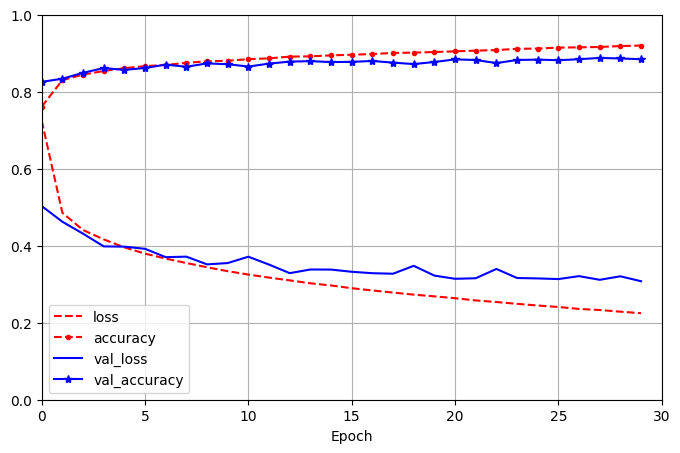

In [27]:
plot_training_history(history)